In [1]:
# https://www.knowledgehut.com/blog/data-science/types-of-classification-in-ml
from sklearn.datasets import make_blobs 
from collections import Counter 
from numpy import where 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Example data: 


C:\Users\johan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


Y_TRAIN
SHAPE:  (10000, 10)
First:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
FShpe:  (10,)


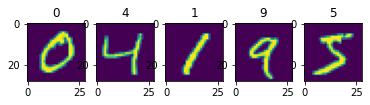

In [2]:
# Loading MNIST Datasets
# Additional Reference for loading & preprocessing the dataset 
# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
import tensorflow.keras.datasets.mnist as mnist_dataset
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

print('Example data: ')
for idx, x in enumerate(zip(x_train[:5], y_train[:5])):
    plt.subplot("15{}".format(idx))
    plt.title(x[1])
    plt.imshow(x[0])

# Cast as float
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Normalize Data
x_train /= 255.0
x_test /= 255.0

# Prepare data for
# x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
# x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Flatten the input (Because we do not use CNN)
x_train = np.array([x.flatten() for x in x_train])
x_test = np.array([x.flatten() for x in x_test])

# Transform Labels
le = OneHotEncoder()
yy = y_train.reshape(-1, 1)
# y_train = le.fit_transform(yy).toarray()
le.fit(yy)
y_train = le.transform(yy).toarray()

yy = y_test.reshape(-1, 1)
# y_test = le.fit_transform(yy).toarray()
y_test = le.transform(yy).toarray()


# print("YY SHape:", yy.shape)
# print("YY1", yy[0])


print("Y_TRAIN")
print("SHAPE: ",y_test.shape)
print("First: ",y_test[0])
print("FShpe: ",y_test[0].shape)



In [3]:

import random
import numpy as np
import pandas as pd
import copy
import time
from numpy import exp
from sklearn.preprocessing import OneHotEncoder

random.seed(42)
np.random.seed(42)

class Network(object):

    def __init__(self, sizes):
        
        '''The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers.'''

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        # helper variables
        self.bias_nitem = sum(sizes[1:])
        self.weight_nitem = sum([self.weights[i].size for i in range(self.num_layers-2)])

    def feedforward(self, a):
        '''Return the output of the network if ``a`` is input.'''
        for b, w in zip(self.biases, self.weights):
            # a = self.sigmoid(np.dot(w,a)+b)
            a = np.dot(w,a)+b
        a = self.softmax(a)
        return a

    # Actifation Functions
    def softmax(self, z):
        e = exp(z)
        e_sum = e.sum()
        if e_sum == 0:
            e_sum = 1
        return e / e_sum

    def sigmoid(self, z):
        '''The sigmoid function.'''
        return 1.0/(1.0+np.exp(-z))

    def relu(self, z):
        def relu_func(x):
            return x if x > 0 else 0
        return np.array(list(map(relu_func, z)))

    def score(self, X, y):

        '''
        @X = data to test
        @y = data-label to test
        @returns = score of network prediction (less is better)
        @ref: https://stats.stackexchange.com/questions/154879/a-list-of-cost-functions-used-in-neural-networks-alongside-applications
        '''

        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            score = np.sum(np.power(predicted-actual,2))
            # print("Accuracy Argmax:", np.argmax(predicted), np.argmax(actual), "Score:",score)
            # txt ="[ "
            # for pred in predicted:
            #     txt += "{}, ".format(pred)
            # print(txt, "]", sum(predicted))
            total_score += score  # mean-squared error
        # total_score /= X.shape[0] 
        # print("Total Score:", total_score)
        return total_score

    def accuracy(self, X, y):

        '''
        @X = data to test
        @y = data-label to test
        @returns = accuracy (%) (more is better)
        '''

        accuracy = 0
        for i in range(X.shape[0]):
            output = self.feedforward(X[i].reshape(-1,1))
            accuracy += int(np.argmax(output) == np.argmax(y[i]))
        return (accuracy / X.shape[0]) * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

class NNGeneticAlgo:

    def __init__(self, n_pops, net_size, mutation_rate, crossover_rate, retain_rate, X, y):

        '''
        n_pops   = How much population do our GA need to create
        net_size = Size of neural network for population members
        mutation_rate = probability of mutating all bias & weight inside our network
        crossover_rate = probability of cross-overing all bias & weight inside out network
        retain_rate = How many to retain our population for the best ones
        X = our data to test accuracy
        y = our data-label to test accuracy
        '''

        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [Network(self.net_size) for i in range(self.n_pops)]
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.retain_rate = retain_rate
        self.X = X[:]
        self.y = y[:]
    
    def get_random_point(self, type):

        '''
        @type = either 'weight' or 'bias'
        @returns tuple (layer_index, point_index)
            note: if type is set to 'weight', point_index will return (row_index, col_index)
        '''

        nn = self.nets[0]
        layer_index, point_index = random.randint(0, nn.num_layers-2), 0
        if type == 'weight':
            row = random.randint(0,nn.weights[layer_index].shape[0]-1)
            col = random.randint(0,nn.weights[layer_index].shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases[layer_index].size-1)
        return (layer_index, point_index)

    def get_all_scores(self):
        return [net.score(self.X, self.y) for net in self.nets]

    def get_all_accuracy(self):
        return [net.accuracy(self.X, self.y) for net in self.nets]

    def crossover(self, father, mother):

        '''
        @father = neural-net object representing father
        @mother = neural-net object representing mother
        @returns = new child based on father/mother genetic information
        '''

        # make a copy of father 'genetic' weights & biases information
        nn = copy.deepcopy(father)

        # cross-over bias
        for _ in range(self.nets[0].bias_nitem):
            # get some random points
            layer, point = self.get_random_point('bias')
            # replace genetic (bias) with mother's value
            if random.uniform(0,1) < self.crossover_rate:
                nn.biases[layer][point] = mother.biases[layer][point]

        # cross-over weight
        for _ in range(self.nets[0].weight_nitem):
            # get some random points
            layer, point = self.get_random_point('weight')
            # replace genetic (weight) with mother's value
            if random.uniform(0,1) < self.crossover_rate:
                nn.weights[layer][point] = mother.weights[layer][point]
        
        return nn
        
    def mutation(self, child):

        '''
        @child_index = neural-net object to mutate its internal weights & biases value
        @returns = new mutated neural-net
        '''

        nn = copy.deepcopy(child)

        # mutate bias
        for _ in range(self.nets[0].bias_nitem):
            # get some random points
            layer, point = self.get_random_point('bias')
            # add some random value between -0.5 and 0.5
            if random.uniform(0,1) < self.mutation_rate:
                nn.biases[layer][point] += random.uniform(-0.5, 0.5)

        # mutate weight
        for _ in range(self.nets[0].weight_nitem):
            # get some random points
            layer, point = self.get_random_point('weight')
            # add some random value between -0.5 and 0.5
            if random.uniform(0,1) < self.mutation_rate:
                nn.weights[layer][point[0], point[1]] += random.uniform(-0.5, 0.5)

        return nn

    def evolve(self):

        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores()))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])
        print("Sorted Score List")
        print("Sorted Score:", [obj[1] for obj in score_list])
        print()
        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]

        # keep only the best one
        retain_num = int(self.n_pops*self.retain_rate)
        score_list_top = score_list[:retain_num]

        # return some non-best ones
        retain_non_best = int((self.n_pops-retain_num) * self.retain_rate)
        for _ in range(random.randint(0, retain_non_best)):
            score_list_top.append(random.choice(score_list[retain_num:]))

        # breed new childs if current population number less than what we want
        while len(score_list_top) < self.n_pops:

            father = random.choice(score_list_top[:retain_num + retain_non_best])
            mother = random.choice(score_list_top[:retain_num + retain_non_best])

            if father != mother:
                new_child = self.crossover(father, mother)
                new_child = self.mutation(new_child)
                score_list_top.append(new_child)
        
        # copy our new population to current object
        self.nets = score_list_top

(500, 784)
(500, 10)
Current iteration : 1
Time taken by far : 2.5 seconds
Current top member's network accuracy: 17.40%

Sorted Score List
Sorted Score: [1.6333689945537313, 1.672389370933085, 1.6967752086665193, 1.696808453123581, 1.74019661314972, 1.7410212070469089, 1.7425912102297554, 1.7436717071799854, 1.7479989640967626, 1.7496176055255668, 1.755816676897764, 1.7630671241077802, 1.7660625451331418, 1.7912904140901484, 1.7987710376468806, 1.7988320485415925, 1.8009948160750462, 1.8128255556344952, 1.8166440500261927, 1.8172487507449318, 1.8231757961677408, 1.8311133046779482, 1.8325161345137542, 1.8348658283215111, 1.8451145964676419, 1.846063713109092, 1.852208573810607, 1.8693522796846447, 1.8941890893946227, 1.8954322325193276]

Current iteration : 2
Time taken by far : 21.7 seconds
Current top member's network accuracy: 18.40%

Sorted Score List
Sorted Score: [1.611028613168428, 1.6333689945537313, 1.672389370933085, 1.6967752086665193, 1.696808453123581, 1.7096799018457203,

C:\Users\johan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp
C:\Users\johan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Current iteration : 4
Time taken by far : 55.6 seconds
Current top member's network accuracy: 23.60%

Sorted Score List
Sorted Score: [1.5125996515148636, 1.5167028881695777, 1.547538982288716, 1.6048584400788843, 1.611028613168428, 1.6333689945537313, 1.6659741380219575, 1.672389370933085, 1.6774216333969971, 1.6888944127886862, 1.6967752086665193, 1.696808453123581, 1.7006898587175867, 1.7085504683436046, 1.7096799018457203, 1.7258215799339673, 1.74019661314972, 1.7437245091535092, 1.7614773964649466, 1.7797811495910896, 1.8502413855241233, nan, 1.7844755135181256, 1.786127821544178, 1.7952349668617906, 1.82698530112706, 1.85560308325271, 1.921132180545685, nan, nan]

Current iteration : 5
Time taken by far : 74.2 seconds
Current top member's network accuracy: 23.60%

Sorted Score List
Sorted Score: [1.5125996515148636, 1.5167028881695777, 1.547538982288716, 1.6048584400788843, 1.611028613168428, 1.6333689945537313, 1.6659741380219575, 1.672389370933085, 1.6774216333969971, 1.6888944

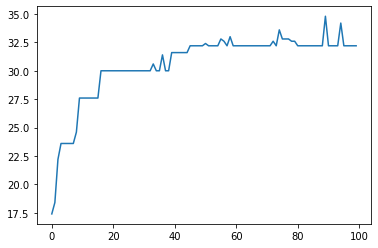

In [4]:
X = x_train[:500]
y = y_train[:500]

# X = x_train[:500]
# y = y_train[:500]

print(X.shape)
print(y.shape)

# parameters
N_POPS = 30
NET_SIZE = [X[0].shape[0],100,10] 
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.4
RETAIN_RATE = 0.4

# start our neural-net & optimize it using genetic algorithm
nnga = NNGeneticAlgo(N_POPS, NET_SIZE, MUTATION_RATE, CROSSOVER_RATE, RETAIN_RATE, X, y)

start_time = time.time()

# run for n iterations
accuracy_history = []
# for i in range(1000):
global_prev_best_accuracy = 0
max_count_after_best = 100
count_after_best = 0
for i in range(100):

    # accuracy = 
    best_current_accuracy = max(nnga.get_all_accuracy())
    if i % 1 == 0:
        print("Current iteration : {}".format(i+1))
        print("Time taken by far : %.1f seconds" % (time.time() - start_time))
        print("Current top member's network accuracy: %.2f%%\n" %best_current_accuracy)
        # print(nnga.get_all_accuracy())
        
    accuracy_history.append(best_current_accuracy)
    if global_prev_best_accuracy < best_current_accuracy:
        global_prev_best_accuracy = best_current_accuracy
        count_after_best = 0
    else:
        count_after_best += 1
    
    if count_after_best > max_count_after_best:
        print("Early Stopped after", count_after_best, "without improvemnet from: ", global_prev_best_accuracy, "Current was:", best_current_accuracy)
        break

    # evolve the population
    nnga.evolve()

import numpy as np
import matplotlib.pyplot as plt
plt.plot(accuracy_history)
plt.show()


C:\Users\johan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


ValueError: shapes (100,784) and (1,784) not aligned: 784 (dim 1) != 1 (dim 0)

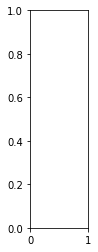

In [5]:
for idx, x in enumerate(zip(x_test[:5], y_test[:5])):
    plt.subplot("15{}".format(idx))
    pred = nnga.nets[0].feedforward(np.array([x[0]]))
    plt.title("{}:{}".format(x[1], pred))
    plt.imshow(np.array(x[0]).reshape((28,28,1)))
    break
plt.show(block=False)

# print("Accuracy on Unseen Data:", Test_acc)


# plt.plot(optimizer.cost_history)
# plt.show()